### Packages and paths

In [1]:
# packages and plot parameters
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import TwoSlopeNorm
import numpy.ma as ma
import glob
import os
import re
from operator import mul
import sys

plt.rcParams['figure.figsize'] = (10,4)

sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/jupyterfiles/") # go to parent dir
from read_binary import *

# add personal functions to path test
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod

### Define relevant functions

### Set up the files and grid, read files

In [2]:
# set the grid
nx=20
ny=16
nz=23

pt = np.array([[8,11,4],
               [10,9,0],
               [12,7,0],
               [18,1,0]])

In [3]:
# read in the files - she did .data but I guess I will do .meta
dirrun = "/scratch2/atnguyen/labsea/layers/run_c67w_layers_03Jun2023_noOL_10d/"
dirIn = dirrun + "diags/BUDG/"
dirGrid = "/scratch2/atnguyen/labsea/GRID_r8/"

In [4]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Salt'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsNbRec': 3,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'seaice_variable_salinity_flag': 0,
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

In [5]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [6]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(23,) (23, 16, 20)


### Ocean and Ice tendency

In [7]:
# set some variables we need
AB_gS=0
t_day = str(int(dt/60/60) * 2)
tsstr = t_day.zfill(10)

# read in data for tendency
file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr + ".meta")
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','PHIBOT','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),np.nan,returnmeta=True,rec=recs[0])
PHIBOT,its,meta = rdmds(os.path.join(dirIn, file_name),np.nan,returnmeta=True,rec=recs[1])
SIheff,its,meta = rdmds(os.path.join(dirIn, file_name),np.nan,returnmeta=True,rec=recs[2])
SIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),np.nan,returnmeta=True,rec=recs[3])

ETAN =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt
PHIBOT = (PHIBOT[1, :, :] - PHIBOT[0, :, :]) / dt
SIheff =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
SIhsnow = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

In [8]:
# ocean
t1i = 0
t2i = 1
t1 = its[t1i]
t2 = its[t2i]

In [9]:
# salt for tendency
# if test3d:
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

SALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),np.nan,returnmeta=True,rec=recs[0])
SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt

In [10]:
tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)
budgO = {}
budgO['fluxes'] = {}
budgI = {}
budgI['fluxes'] = {}
budgOI = {}

# ocean

budgO['fluxes']['tend'] = tmptend
budgO['tend'] = np.nansum(tmptend,axis=0)

# ice
if myparms['seaice_variable_salinity_flag'] == 0:
    budgI['tend'] = myparms['SIsal0'] * SIheff * myparms['rhoi'] * RAC
else:
    budgI['tend'] = 0 * SIheff * myparms['rhoi'] * RAC

# ocean and ice
budgOI['tend'] = budgO['tend'] + budgI['tend']

In [11]:
# clear memory
del ETAN, PHIBOT, SIheff, SIhsnow, tmptend

In [12]:
# Check 1
# fig = plt.figure()
# plt.subplot(131)
# plt.pcolormesh(budgO['fluxes']['tend'][0])
# plt.colorbar()
# plt.subplot(132)
# plt.pcolormesh(budgI['tend'])
# plt.colorbar()
# plt.subplot(133)
# plt.pcolormesh(budgOI['tend'])
# plt.colorbar()

### Vertical convergence

This might be reading in the wrong shape, perhaps this is why there is a bug

In [13]:
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])

if len(recs)>2:
    SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
else:
    # SRELAX is not in the file, we can construct it ourselves
    SRELAX = np.zeros((ny,nx))

In [14]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])

In [15]:
if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['zconv'] = SFLUX + oceSPflx
budgI['zconv'] = -budgO['zconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['zconv'] = budgO['zconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['zconv']=-oceSflux

In [16]:
nr = mygrid['RC'].shape[0]
trWtop = -(ADVr_SLT+DFrE_SLT+DFrI_SLT+KPPg_SLT)*myparms['rhoconst']    # g/s
print(trWtop.shape)
tmp1 = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)       # g/m^2/s
tmp1 = tmp1 * RAC3    # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[:-1,:,:]        # g/s
trWtop[0,:,:] = budgO['zconv'] * RAC    # top layer is surface flux   g/s

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['fluxes']['trWtop'] = trWtop
budgO['fluxes']['trWbot'] = trWbot

budgI['fluxes']['trWtop'] = -RAC*0
budgI['fluxes']['trWbot'] = budgO['fluxes']['trWtop'][0,:,:]  # surface because ice

budgO['fluxes']['zconv'] = budgO['fluxes']['trWtop'] - budgO['fluxes']['trWbot']
budgO['zconv'] = RAC * budgO['zconv']
budgI['zconv'] = RAC * budgI['zconv']
budgOI['zconv'] = budgO['zconv'] + budgI['zconv']

(23, 16, 20)


In [17]:
# example check, nz-1 ny nx
# print(trWtop[1:,:,:].shape)
# print(trWtop[1:len(mygrid['RC']),:,:].shape)

# check figure 1
# fig = plt.figure()
# plt.subplot(131)
# plt.pcolormesh(budgO['fluxes']['zconv'][0])
# plt.colorbar()
# plt.subplot(132)
# plt.pcolormesh(budgI['zconv'])
# plt.colorbar()
# plt.subplot(133)
# plt.pcolormesh(budgOI['zconv'])
# plt.colorbar()

In [18]:
# delete the arrays from memory
del oceSPflx,SFLUX,oceSflux,WSLTMASS,SRELAX,oceSPtnd,KPPg_SLT,ADVr_SLT,DFrE_SLT,DFrI_SLT,tmp1,trWtop,trWbot

### Horizontal convergence

In [19]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)

budgO['fluxes']['hconv'] = calc_UV_conv_1face(tmpUo,tmpVo)
budgO['hconv'] = calc_UV_conv_1face(np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0)).reshape((ny,nx))

In [20]:
# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])

varnames = np.array(["DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
if len(recs)>2:
    DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
else:
    # not in the file, we can construct it ourselves
    DFxEHEFF = np.zeros((ny,nx))
    DFyEHEFF = np.zeros((ny,nx))
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)

In [21]:
budgI['hconv'] = calc_UV_conv_1face(tmpUi, tmpVi).reshape((ny,nx))
budgOI['hconv'] = (budgO['hconv'] + budgI['hconv']).reshape((ny,nx))

In [22]:
del tmpUo, tmpVo, tmpUi, tmpVi, ADVx_SLT, ADVy_SLT, DFxE_SLT, DFyE_SLT, ADVxHEFF, ADVyHEFF, DFxEHEFF, DFyEHEFF

In [23]:
# Check 1
# fig = plt.figure()
# ax = plt.subplot(221)
# pcm = ax.pcolormesh(tmpUo[0])
# fig.colorbar(pcm, ax=ax,cmap="jet")
# ax = plt.subplot(222)
# pcm = ax.pcolormesh(tmpUo[10])
# fig.colorbar(pcm, ax=ax,cmap="jet")
# ax = plt.subplot(223)
# pcm = ax.pcolormesh(tmpVo[0])
# fig.colorbar(pcm, ax=ax,cmap="jet")
# ax = plt.subplot(224)
# pcm = ax.pcolormesh(tmpVo[10])
# fig.colorbar(pcm, ax=ax,cmap="jet")

# Check 2
# fig = plt.figure()
# ax = plt.subplot(141)
# pcm = ax.pcolormesh(budgO["fluxes"]["tend"][0,:,:])
# fig.colorbar(pcm, ax=ax)
# ax = plt.subplot(142)
# pcm = ax.pcolormesh(budgO["fluxes"]["zconv"][0,:,:])
# fig.colorbar(pcm, ax=ax)
# ax = plt.subplot(143)
# pcm = ax.pcolormesh(budgO["fluxes"]["hconv"][0,:,:])
# fig.colorbar(pcm, ax=ax)
# ax = plt.subplot(144)
# pcm = ax.pcolormesh(budgO["fluxes"]["tend"][0,:,:] - budgO["fluxes"]["zconv"][0,:,:] - budgO["fluxes"]["hconv"][0,:,:])
# fig.colorbar(pcm, ax=ax)

# Check 3
# fig = plt.figure()
# plt.subplot(131)
# plt.pcolormesh(budgO['fluxes']['hconv'][0])
# plt.colorbar()
# plt.subplot(132)
# plt.pcolormesh(budgI['hconv'])
# plt.colorbar()
# plt.subplot(133)
# plt.pcolormesh(budgOI['hconv'])
# plt.colorbar()

# Check 4
# resid = budgO["fluxes"]["tend"][:,:,:] - budgO["fluxes"]["zconv"][:,:,:] - budgO["fluxes"]["hconv"][:,:,:]
# print(np.nansum(resid))
# print(budgO["fluxes"]["tend"][9,14,0],budgO["fluxes"]["hconv"][9,14,0],budgO["fluxes"]["zconv"][9,14,0],resid[9,14,0])
# print(budgO["fluxes"]["tend"][9,14,0]-budgO["fluxes"]["hconv"][9,14,0]-budgO["fluxes"]["zconv"][9,14,0],resid[9,14,0])

### Complete list of output

In [24]:
# Calculations for budgOI

# this might have wrong indexing
a = budgOI['tend'] * hfC1p
b = budgOI['hconv'] * hfC1p
c = budgOI['zconv'] * hfC1p
budgetOI = np.zeros(3)
budgetOI[0] = np.nansum(a) / np.nansum(RACgp)
budgetOI[1] = np.nansum(b) / np.nansum(RACgp)
budgetOI[2] = np.nansum(c) / np.nansum(RACgp)
print(f"{budgetOI[0] - budgetOI[1] - budgetOI[2]:.4e}", end=' ')
print()

# Calculations for budgI
a = budgI['tend'] * hfC1p
b = budgI['hconv'] * hfC1p
c = budgI['zconv'] * hfC1p
budgetI = np.zeros(3)
budgetI[0] = np.nansum(a) / np.nansum(RACgp)
budgetI[1] = np.nansum(b) / np.nansum(RACgp)
budgetI[2] = np.nansum(c) / np.nansum(RACgp)
print(f"{budgetI[0] - budgetI[1] - budgetI[2]:.4e}", end=' ')
print(f"{(budgetI[0] - budgetI[1] - budgetI[2])/budgetI[0]:.4e}", end=' ')

print()

# Calculations for budgO
a = budgO['tend'] * hfC1p
b = budgO['hconv'] * hfC1p
c = budgO['zconv'] * hfC1p
budgetO = np.zeros(3)
budgetO[0] = np.nansum(a) / np.nansum(RACgp)
budgetO[1] = np.nansum(b) / np.nansum(RACgp)
budgetO[2] = np.nansum(c) / np.nansum(RACgp)
print(f"{budgetO[0] - budgetO[1] - budgetO[2]:.4e}")

4.2764e-14 
7.5894e-19 -1.1290e-15 
4.2761e-14


### Start creating diags

In [25]:
# # This is for basins, I don't think we need this
listDiags = ['glo_vol_ocn', 'glo_vol_tot', 'glo_vol_ice']

#### I think we should be calculaating m^3/s so that will be done here

In [26]:
# global sum 
# Calculations
tmp1,a = calc_mskmean_T_mod(budgOI, hfC1p, RACgp,'extensive')
glo_vol_tot = [tmp1['tend'], tmp1['hconv'], tmp1['zconv']]

tmp1,a = calc_mskmean_T_mod(budgO, hfC1p, RACgp,'extensive')
glo_vol_ocn = [tmp1['tend'], tmp1['hconv'], tmp1['zconv']]

tmp1,a = calc_mskmean_T_mod(budgI, hfC1p, RACgp,'extensive')
glo_vol_ice = [tmp1['tend'], tmp1['hconv'], tmp1['zconv']]  # see /home/atnguyen/matlab/gcmfaces/gcmfaces_diags/diags_select.m

# Package results
onediag = {}
onediag['listTimes'] = myparms['yearFirst'] + t1 * myparms['timeStep'] / 86400 / 365.25
onediag['listSteps'] = t2

for jj in listDiags:
    onediag[jj] = eval(jj)

In [27]:
print(budgO['fluxes']['tend'][0, 11, 8] - budgO['fluxes']['hconv'][0, 11, 8] - budgO['fluxes']['zconv'][0, 11, 8])
print(budgO['fluxes']['tend'][0, 11, 8],budgO['fluxes']['hconv'][0, 11, 8], budgO['fluxes']['zconv'][0, 11, 8])

print(budgO['fluxes']['tend'][1, 11, 8] - budgO['fluxes']['hconv'][1, 11, 8] - budgO['fluxes']['zconv'][1, 11, 8])
print(budgO['fluxes']['tend'][1, 11, 8],budgO['fluxes']['hconv'][1, 11, 8], budgO['fluxes']['zconv'][1, 11, 8])

2.4080276489257812e-05
-1806790362.3374097 -2665444716.05682 858654353.7193861
4.082918167114258e-06
-26909396.399174422 -214400784.44756782 187491388.04838932


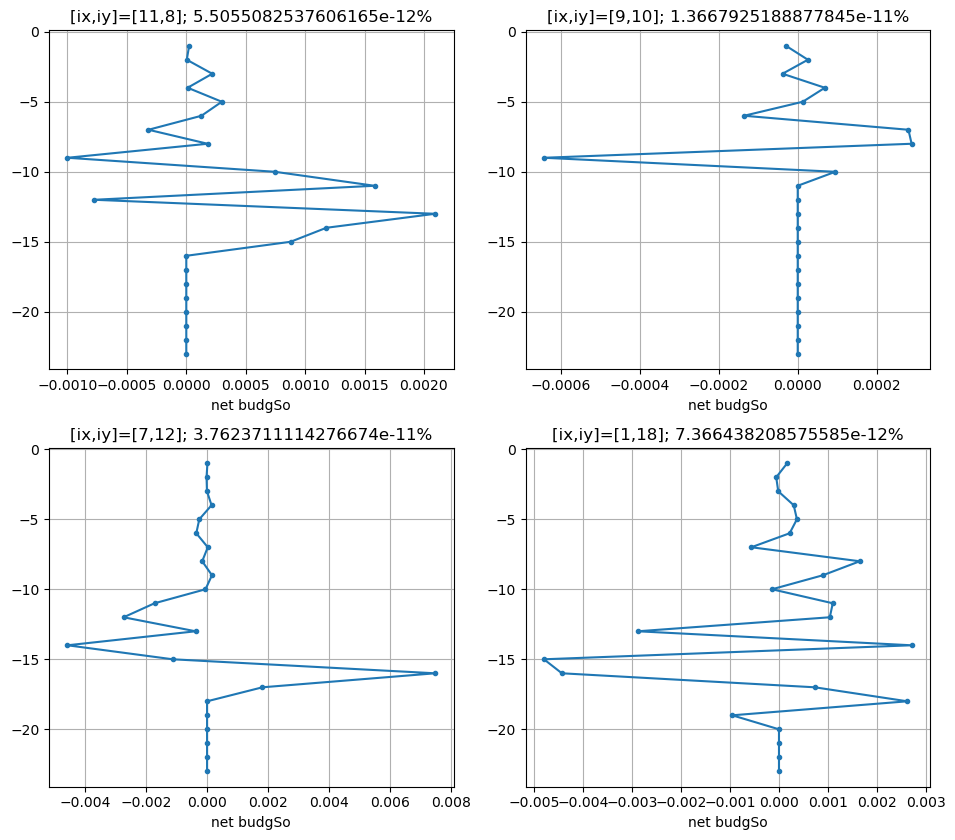

In [28]:
# Figure 1
plt.figure(1, figsize=(9.5, 8.5))
aa = np.zeros((nz, 4))

# four figures labeled n
for n in range(1, 5):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = budgO['fluxes']['tend'][:, iy, ix] - budgO['fluxes']['hconv'][:, iy, ix] - budgO['fluxes']['zconv'][:, iy, ix]
    #aa[:, n-1] = budgO['tend'][iy, ix] - budgO['hconv'][0,iy, ix] - budgO['zconv'][iy, ix]

    plt.subplot(2, 2, n)
    plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    plt.grid()
    plt.xlabel(f"net budg{strbudg[0]}o")
    plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")
        
plt.tight_layout()
plt.show()

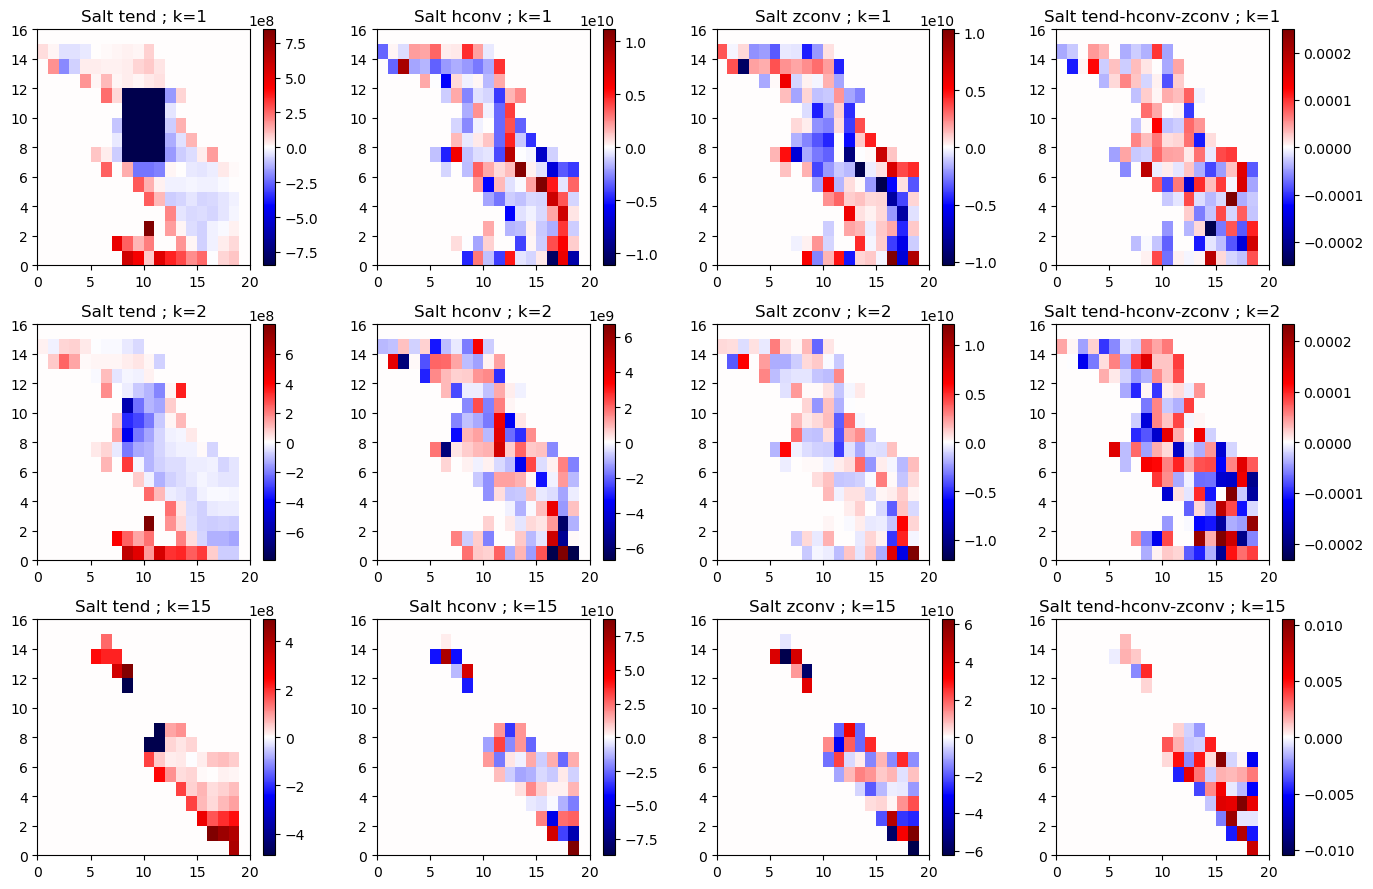

In [29]:
# Figure 2
a = budgO['fluxes']['tend'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
b = budgO['fluxes']['hconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
c = budgO['fluxes']['zconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))

a[np.isnan(a)] = 0
b[np.isnan(b)] = 0
c[np.isnan(c)] = 0

klev = [1, 2, 15]
fig, axes = plt.subplots(3, 4, figsize=(14, 9))

for idx, k1 in enumerate(klev):
    str_k = f"; k={k1}"
    for j, (data, title) in enumerate([(a, 'tend'), (b, 'hconv'), (c, 'zconv'), (a-b-c, 'tend-hconv-zconv')]):
        ax = axes[idx, j]
        pcm = ax.pcolormesh(data[k1-1,:, :], cmap='seismic', vmin=-0.99*abs(data[k1-1,:, :].max()), vmax=0.99*abs(data[k1-1,:, :].max()))
        fig.colorbar(pcm, ax=ax)
        ax.set_title(f"{strbudg} {title} {str_k}")

plt.tight_layout()
plt.show()

In [30]:
a = budgO['tend'] * hfC1p
d = budgI['tend'] * hfC1p
#b = budgO['hconv'].reshape(16,20) * hfC1p
#f = budgI['hconv'].reshape(16,20) * hfC1p

b = budgO['hconv'] * hfC1p
f = budgI['hconv'] * hfC1p
c = budgO['zconv'] * hfC1p
g = budgI['zconv'] * hfC1p

a[np.isnan(a)] = 0
b[np.isnan(b)] = 0
c[np.isnan(c)] = 0
d[np.isnan(d)] = 0
f[np.isnan(f)] = 0
g[np.isnan(g)] = 0

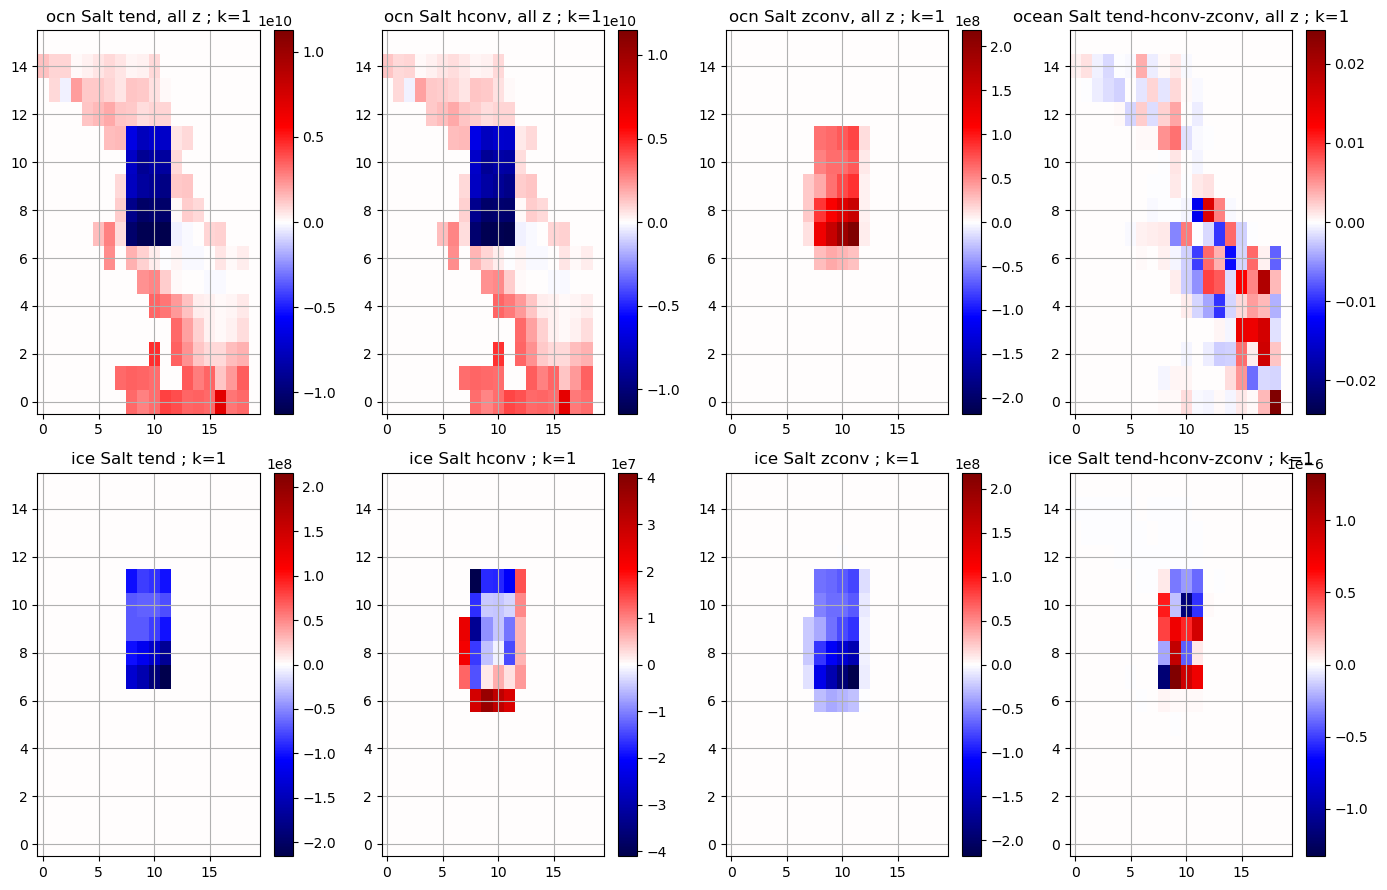

In [31]:
ix = np.arange(nx)
iy = np.arange(ny)
# 0 is the surface
k = 0

fig, axes = plt.subplots(2, 4, figsize=(14, 9))
str_k = f"; k={k+1}"

for j, (data, title_prefix, title_suffix) in enumerate([(a, 'ocn', 'tend, all z'), 
                                                        (b, 'ocn', 'hconv, all z'), 
                                                        (c, 'ocn', 'zconv, all z'),
                                                        (a-b-c, 'ocean', 'tend-hconv-zconv, all z'),
                                                        (d, 'ice', 'tend'),
                                                        (f, 'ice', 'hconv'),
                                                        (g, 'ice', 'zconv'),
                                                        (d-f-g, 'ice', 'tend-hconv-zconv')]):

    if len(data.shape) > 2:
        ax = axes[j//4, j%4]
        pcm = ax.pcolormesh(ix, iy, data[k,:,:], cmap='seismic', vmin=-0.99*np.nanmax(abs(data)), vmax=0.99*np.nanmax(abs(data)))
        fig.colorbar(pcm, ax=ax)
        ax.grid()
        ax.set_title(f"{title_prefix} {strbudg} {title_suffix} {str_k}")
    else:
        ax = axes[j//4, j%4]
        pcm = ax.pcolormesh(ix, iy, data[:,:], cmap='seismic', vmin=-0.99*np.nanmax(abs(data)), vmax=0.99*np.nanmax(abs(data)))
        fig.colorbar(pcm, ax=ax)
        ax.grid()
        ax.set_title(f"{title_prefix} {strbudg} {title_suffix} {str_k}")

plt.tight_layout()
plt.show()